## Data Wrangling & Exploratory Data Analysis: Chatbot 'Yoldi' 

This notebook encompasses the initial stages of developing a chatbot, 'Yoldi', designed to automate responses for multiple brands on social media platforms. The key steps in this notebook include:

### 1. Data Acquisition
- **Objective**: Load the dataset from the database sampling 250k records for chatbot development. Whole dataset for scaling the project might be possible. 
- **Methodology**: ETL pipeline creation - Use PostgreSQL to create a database, called customer_support, create the schema and set it up. Then, upload the csv file to the database. Finally, use SQL to load the dataset with aggregation and optimize  processing. 

### 2. Data Wrangling and Cleaning
- **Objective**: Prepare the dataset for analysis and model training.
- **Steps Involved**:
  - Filter out inbound queries(users) and responses from Customer Support.
  - Handle missing data, duplicates, and other data inconsistencies.
  - Cleaning text data tecniques with regex and advanced NLP with SpaCy and NLTK.
  - Link user queries with corresponding Customer Support responses.

### 3. Exploratory Data Analysis (EDA)
- **Objective**: Gain insights from the data through visualization and basic statistics.
- **Techniques Used**:
  - Visualize the distribution of queries over time.
  - Analyze the common themes or topics in customer queries.
  - Understand the response patterns of Customer Support.

### 4. Initial Data Insights
- **Objective**: Draw preliminary conclusions from the EDA.
- **Key Areas**:
  - Understanding the nature and complexity of queries.
  - Assessing the efficiency of customer support responses.


In [1]:
import logging
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import nltk
import re
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import plotly.express as px
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, String, Boolean, DateTime
import psycopg2
from gensim import corpora
from gensim.models import LdaMulticore, CoherenceModel
from gensim.corpora.dictionary import Dictionary

#### Data Acquisition: PostgreSQL

In [ ]:
# # Fetching the password from environment variable
# db_password = os.environ.get('DATABASE_PASSWORD')

# # Ensure the password is set
# if db_password is None:
#     raise ValueError("Database password environment variable not set")

# # Database connection details
# username = 'postgres'  # replace with your username
# host = 'localhost'
# database = 'customer_support'
# db_password = 'DATABASE_PASSWORD'

# # Creating database connection URL
# db_url = f"postgresql://{username}:{db_password}@{host}/{database}"

# # Create a database engine
# engine = create_engine(db_url)

# # testing the connection
# try:
#     with engine.connect() as conn:
#         print("Successfully connected to the database!")
# except Exception as e:
#     print(f"An error occurred: {e}")


In [ ]:
# # creating table - define metadata
# metadata = MetaData()

# # Define the 'tweets' table
# tweets_table = Table('tweets', metadata,
#                      Column('tweet_id', Integer, primary_key=True),
#                      Column('author_id', String),
#                      Column('inbound', Boolean),
#                      Column('created_at', DateTime),
#                      Column('text', String),
#                      Column('response_tweet_id', Integer),
#                      Column('in_response_to_tweet_id', Integer)
#                     )

# # creating the table
# metadata.create_all(engine)

In [ ]:
# conn_info = "dbname='customer_support' user='postgres' host='localhost' password='DePorLo*****'"
# conn = psycopg2.connect(conn_info)
# cur = conn.cursor()

# with open('../data/raw/twcs.csv', 'r') as f:
#     cur.copy_expert("COPY tweets FROM STDIN WITH CSV HEADER", f)
#     conn.commit()

# cur.close()
# conn.close()

In [ ]:
# dotenv_path = os.path.join(os.getcwd(), '.env')
# # Load the .env file
# dotenv.load_dotenv(dotenv_path)

# # Retrieve the environment variable
# db_password = os.environ.get('DATABASE_PASSWORD')
# if db_password is None:
#     raise ValueError("Database password environment variable not set")
# else:
#     print("Database password loaded successfully")

In [2]:
DB_USERNAME = 'postgres'
DB_PASSWORD = os.environ.get('DATABASE_PASSWORD')
DB_HOST = 'localhost'
DB_NAME = 'customer_support'
SAMPLE_QUERY = """
SELECT 
    t1.tweet_id AS query_id, 
    t1.text AS query_text, 
    t1.inbound AS query_inbound,
    t1.response_tweet_id AS query_response_tweet_id,
    t1.in_response_to_tweet_id AS query_in_response_to_tweet_id,
    t2.tweet_id AS response_id, 
    t2.text AS response_text,
    t2.inbound AS response_inbound
FROM 
    tweets AS t1
JOIN 
    tweets AS t2 ON t1.tweet_id = t2.in_response_to_tweet_id
WHERE 
    t1.inbound = TRUE AND t2.inbound = FALSE
ORDER BY 
    RANDOM() 
LIMIT 500000;
"""
# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Function to create a database engine
def create_db_engine(username, password, host, database):
    try:
        db_url = f"postgresql://{username}:{password}@{host}/{database}"
        engine = create_engine(db_url)
        logging.info("Database engine created successfully")
        return engine
    except Exception as e:
        logging.error(f"Error creating database engine: {e}")
        raise

# Function to test database connection
def test_db_connection(engine):
    try:
        with engine.connect() as conn:
            logging.info("Successfully connected to the database")
    except Exception as e:
        logging.error(f"An error occurred while connecting to the database: {e}")
        raise

# Fetching the password from environment variable
db_password = os.environ.get('DATABASE_PASSWORD')
if db_password is None:
    raise ValueError("Database password environment variable not set")

# creating engine and testing
engine = create_db_engine(DB_USERNAME, DB_PASSWORD, DB_HOST, DB_NAME)
test_db_connection(engine)

# function to sample data
def sample_data(conn, query):
    """Sample data from the database.
    conn: connection previously created for the database.
    query: PostgreSQL query to sample the data.
    Returns: dataframe.
    """

    try:
        logging.info("Starting function execution: sample_data")
        return pd.read_sql_query(query, conn)
    except Exception as e:
        logging.error(f"Error in your_function: {e}")
        raise
    else:
        logging.info("Completed execution of function: sample_data")
    
# executing function to sample data and save it to folder as csv
sampled_data = sample_data(engine, SAMPLE_QUERY)
sampled_data.to_csv('../data/raw/df_sample.csv', index=False)


2023-11-30 18:14:49,641 - INFO - Database engine created successfully
2023-11-30 18:14:49,689 - INFO - Successfully connected to the database
2023-11-30 18:14:49,690 - INFO - Starting function execution: sample_data


### Data Loading: 

We load the data as the final stage of the ETL pipeline from the PostgreSQL database. 

In [2]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# file path
file_path = '../data/raw/df_sample.csv'

#function to load
def load_data(file_path, chunk_size=1000):
    """
    Load data from a CSV file in chunks to manage memory usage.
    """
    try:
        logging.info("Starting execution of load_data")
        chunk_list = []
        for chunk in pd.read_csv(file_path, chunksize=chunk_size):
            chunk_list.append(chunk)
        df = pd.concat(chunk_list, ignore_index=True)
        logging.info("Data loading completed successfully")
        return df
    except Exception as e:
        logging.error(f"Error loading data from %s: %s:", file_path, e)
        return None

# loading data to df
df = load_data(file_path=file_path)
# checking dataframe 
df.head(10)

2023-12-04 11:29:57,720 - INFO - Starting execution of load_data
2023-12-04 11:30:00,152 - INFO - Data loading completed successfully


,query_id,query_text,query_inbound,query_response_tweet_id,query_in_response_to_tweet_id,response_id,response_text,response_inbound
0,1515,I’d like at least one month to go by where I d...,True,1514,NaN,1514,"@116022 Hello, this does not sound good. Can ...",False
1,425816,@AirbnbHelp Klasse! Vielen Dank dafür!\nKönnte...,True,425815,425817.0,425815,"@216279 Hi Tom, we've escalated your case to o...",False
2,354377,"@NortonSupport Will do, thanks",True,354378,354376.0,354378,@200249 You're welcome. :) -Steffi,False
3,2231678,@AdobeCare Report a site published Photoshop +...,True,2231677,2231679.0,2231677,"@651172 Hi Bianko, you can submit your report ...",False
4,810064,@British_Airways how is Nairobi airport develo...,True,810062,NaN,810062,@313003 you soon. You can always check our lou...,False
5,1712599,@Uber_Support It dosent accept my email adress,True,1712601,1712598.0,1712601,@518730 We're here to help! Send us a DM with ...,False
6,2884253,What's with Cyber Monday @116062 tried to orde...,True,2884252,NaN,2884252,@800085 Thank you for reaching out to us. We a...,False
7,1024285,@AmazonHelp \n発送通知前に業者にキャンセルリクエストを送り、確認メールに「出品...,True,1024284,NaN,1024284,@362400 DMでもご連絡いただいておりましたので、そちらにご返答させていただきました。...,False
8,459090,@Uber_Support why are my last trips not proces...,True,459089,NaN,459089,@224031 Thank you for bringing this to our att...,False
9,288505,@Delta Hey looks like there may be rough weath...,True,"288504,288506",NaN,288504,@184729 make a change https://t.co/K5eDQ2qkZj....,False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 8 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   query_id                       500000 non-null  int64  
 1   query_text                     500000 non-null  object 
 2   query_inbound                  500000 non-null  bool   
 3   query_response_tweet_id        500000 non-null  object 
 4   query_in_response_to_tweet_id  185327 non-null  float64
 5   response_id                    500000 non-null  int64  
 6   response_text                  500000 non-null  object 
 7   response_inbound               500000 non-null  bool   
dtypes: bool(2), float64(1), int64(2), object(3)
memory usage: 23.8+ MB


#### Data Cleaning: 

Below we clean the data as a preparation for exploring it in EDA further below.

In [4]:
# function to perform basic cleaning text for more advanced cleaning and preprocessing
def custom_clean_text(text):
    """
    Perform custom cleaning of text data for Seq2Seq model preparation.
    text (str): The text to be cleaned.
    Returns:
    str: Cleaned text.
    """
    try:
        # Remove URLs, user mentions, hashtags, and special characters
        text = re.sub(r'http\S+|@\w+|#\w+|[^\w\s]', '', text)
        # Convert to lowercase and remove extra spaces
        text = ' '.join(text.lower().strip().split())
        return text
    except Exception as e:
        logging.error(f"Error in cleaning text for Seq2Seq: {e}")
        return None

# applying function
try:
    df['query_text'] = df['query_text'].apply(custom_clean_text)
    df['response_text'] = df['response_text'].apply(custom_clean_text)
    logging.info("Text cleaning for Seq2Seq completed successfully")
except Exception as e:
    logging.error(f"Error during Seq2Seq text cleaning process: {e}")

2023-12-04 11:30:11,977 - INFO - Text cleaning for Seq2Seq completed successfully


In [5]:
try:
    # Dropping rows with NaN values in 'query_text' and 'response_text' columns
    df.dropna(subset=['query_text', 'response_text'], inplace=True)
    
    # Removing duplicate rows based on 'query_id' and 'response_id' to avoid redundancy
    df.drop_duplicates(subset=['query_id', 'response_id'], inplace=True)
    
    logging.info("Dropping NaN values and duplicates completed successfully")
except Exception as e:
    logging.error(f"Error during dropping NaN values and duplicates: {e}")

2023-12-04 11:30:15,543 - INFO - Dropping NaN values and duplicates completed successfully


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 8 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   query_id                       500000 non-null  int64  
 1   query_text                     500000 non-null  object 
 2   query_inbound                  500000 non-null  bool   
 3   query_response_tweet_id        500000 non-null  object 
 4   query_in_response_to_tweet_id  185327 non-null  float64
 5   response_id                    500000 non-null  int64  
 6   response_text                  500000 non-null  object 
 7   response_inbound               500000 non-null  bool   
dtypes: bool(2), float64(1), int64(2), object(3)
memory usage: 23.8+ MB


In [7]:
df.head()

,query_id,query_text,query_inbound,query_response_tweet_id,query_in_response_to_tweet_id,response_id,response_text,response_inbound
0,1515,id like at least one month to go by where i do...,True,1514,NaN,1514,hello this does not sound good can you dm the ...,False
1,425816,klasse vielen dank dafür könntet ihr dann bitt...,True,425815,425817.0,425815,hi tom weve escalated your case to our special...,False
2,354377,will do thanks,True,354378,354376.0,354378,youre welcome steffi,False
3,2231678,report a site published photoshop crack,True,2231677,2231679.0,2231677,hi bianko you can submit your report here let ...,False
4,810064,how is nairobi airport developing have you got...,True,810062,NaN,810062,you soon you can always check our lounge locat...,False


#### EDA: Exploratory Data Analysis

In this stage we take the data previously cleaned and we start aggregating when necessary to create visualizations that will provide insights from the data. We will also generate functions to retrieve insights from data which could enhance our understanding of the nature of queries and responses from customer support.

#### Sentiment Analysis with NLTK for EDA:

Using NLTK module, we will perform initial text preprocessing. It is crucial for the EDA stage to generate analysis and plots that help us understand the nature of the data and possible transformations to apply in future stages. After that, we will also perform other tecniques that will allow us to have a cleaner dataset and text structure so we can create some features in next stages.

In [8]:
nltk.download('vader_lexicon')

# initialize SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis to the processed text
df['sentiment'] = df['query_text'].apply(lambda x: sia.polarity_scores(x)['compound'] if x else 0)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/camilods16/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#### Sentiment Classification with Threshold: 

We classify the sentiment score column based on a threshold of 0.2 to -0.2 as neutral, above 0.2 would be classified as positive and below -0.2 as negative. Then, we will add the column to the dataframe and close the initial cleaning stage to continue with EDA.

In [9]:
# creating a column sentiment_class
def classify_sentiment(score):
    """
    Classify the sentiment of the tweets based on a sentiment score.
    Returns 'Positive', 'Negative', or 'Neutral' based on the score.
    score (float): The sentiment score to classify.
    Returns:
    str: The sentiment classification ('Positive', 'Negative', 'Neutral').
    """
    try:
        if score > 0.2:
            return 'Positive'
        elif score < -0.2:
            return 'Negative'
        else:
            return 'Neutral'
    except Exception as e:
        logging.error(f"Error in classifying sentiment: {e}")
        # Optionally, return a default classification or raise the exception
        return 'Neutral'  

# applying sentiment classification with threshold
try:
    df['sentiment_class'] = df['sentiment'].apply(classify_sentiment)
    logging.info("Sentiment classification applied successfully")
except Exception as e:
    logging.error(f"Error applying sentiment classification to DataFrame: {e}")

2023-12-04 15:51:26,165 - INFO - Sentiment classification applied successfully


In [10]:
df.head()

,query_id,query_text,query_inbound,query_response_tweet_id,query_in_response_to_tweet_id,response_id,response_text,response_inbound,sentiment,sentiment_class
0,1515,id like at least one month to go by where i do...,True,1514,NaN,1514,hello this does not sound good can you dm the ...,False,-0.5423,Negative
1,425816,klasse vielen dank dafür könntet ihr dann bitt...,True,425815,425817.0,425815,hi tom weve escalated your case to our special...,False,-0.5994,Negative
2,354377,will do thanks,True,354378,354376.0,354378,youre welcome steffi,False,0.4404,Positive
3,2231678,report a site published photoshop crack,True,2231677,2231679.0,2231677,hi bianko you can submit your report here let ...,False,0.0000,Neutral
4,810064,how is nairobi airport developing have you got...,True,810062,NaN,810062,you soon you can always check our lounge locat...,False,0.0000,Neutral


In [11]:
# function to analyze the length of customer queries
def analyze_message_length(df, column_name):
    """
    Analyze the length of messages in a specified column.
    Args:
    df (pd.DataFrame): DataFrame containing the text data.
    column_name (str): Column name of the text data.
    Returns:
    pd.Series: A Series with the length of each message.
    """
    try:
        message_length = df[column_name].str.len()
        logging.info(f"Message length analysis for {column_name} completed successfully")
        return message_length
    except Exception as e:
        logging.error(f"Error in analyzing message length for {column_name}: {e}")
        return None

# applying the function
# analyzing the length of queries and responses
query_message_length = analyze_message_length(df, 'query_text')
response_message_length = analyze_message_length(df, 'response_text')

2023-12-04 16:32:41,184 - INFO - Message length analysis for query_text completed successfully
2023-12-04 16:32:41,308 - INFO - Message length analysis for response_text completed successfully


In [12]:
# function to retrieve common words and phrases for further analysis and complement of word clouds
def common_phrases_words(df, column_name, top_n=20):
    """
    Identify and count the most common phrases or words in a specified column.
    Args:
    df (pd.DataFrame): DataFrame containing the text data.
    column_name (str): Column name of the text data.
    top_n (int): Number of top phrases or words to return.
    Returns:
    list: List of tuples with the most common phrases/words and their counts.
    """
    try:
        all_words = ' '.join(df[column_name].dropna()).split()
        word_counts = Counter(all_words).most_common(top_n)
        logging.info(f"Top {top_n} common phrases/words analysis for {column_name} completed")
        return word_counts
    except Exception as e:
        logging.error(f"Error in common phrases/words analysis for {column_name}: {e}")
        return []

# applying the function: analyzing common phrases/words in queries and responses
common_phrases_queries = common_phrases_words(df, 'query_text', top_n=20)
common_phrases_responses = common_phrases_words(df, 'response_text', top_n=20)

2023-12-04 16:45:29,092 - INFO - Top 20 common phrases/words analysis for query_text completed
2023-12-04 16:45:30,574 - INFO - Top 20 common phrases/words analysis for response_text completed


In [15]:
# Display the results
print("Common phrases in queries:", common_phrases_queries)
print("Common phrases in responses:", common_phrases_responses)

Common phrases in queries: [('i', 263697), ('to', 260983), ('the', 250099), ('a', 163654), ('my', 162450), ('and', 151241), ('is', 122743), ('for', 113478), ('it', 109479), ('you', 109008), ('on', 103409), ('in', 95213), ('of', 78314), ('this', 74281), ('me', 68444), ('have', 68274), ('not', 64369), ('with', 58554), ('your', 54769), ('that', 52944)]
Common phrases in responses: [('to', 361745), ('you', 351675), ('the', 284379), ('your', 213464), ('we', 182137), ('for', 172504), ('us', 167148), ('a', 157143), ('can', 149347), ('and', 147241), ('this', 144966), ('please', 127285), ('dm', 122606), ('with', 108018), ('in', 78117), ('our', 76079), ('on', 75973), ('help', 72509), ('hi', 72143), ('sorry', 71734)]


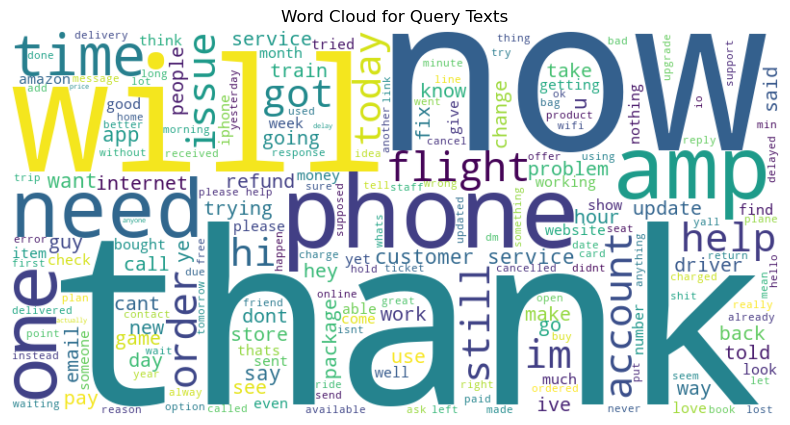

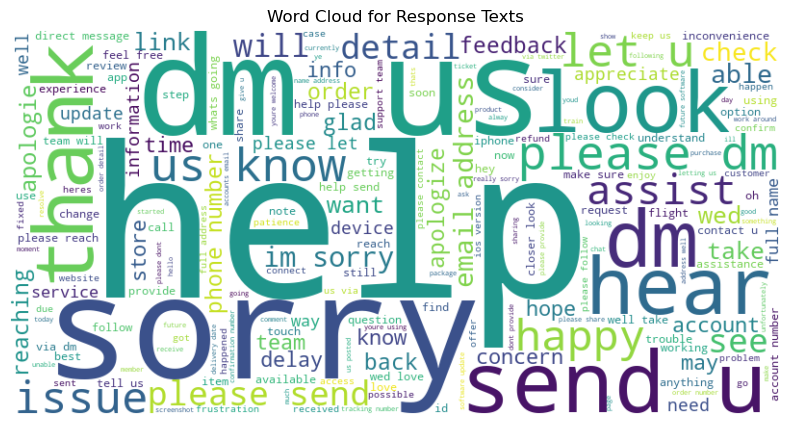

In [13]:
# word clouds generation for visual EDA
def generate_query_response_word_clouds(df):
    """
    Generate word clouds for query and response texts.
    Args:
    df (pd.DataFrame): DataFrame containing query and response texts.
    """
    try:
        # Concatenate all query and response texts
        query_text = ' '.join(df['query_text'].dropna())
        response_text = ' '.join(df['response_text'].dropna())

        # Define common parameters for word clouds
        wc_params = {
            'stopwords': STOPWORDS,
            'background_color': 'white',
            'width': 800,
            'height': 400
        }

        # Create word cloud for query texts
        query_wordcloud = WordCloud(**wc_params).generate(query_text)
        plt.figure(figsize=(10, 5))
        plt.imshow(query_wordcloud, interpolation='bilinear')
        plt.title('Word Cloud for Query Texts')
        plt.axis('off')
        plt.show()

        # Create word cloud for response texts
        response_wordcloud = WordCloud(**wc_params).generate(response_text)
        plt.figure(figsize=(10, 5))
        plt.imshow(response_wordcloud, interpolation='bilinear')
        plt.title('Word Cloud for Response Texts')
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"Error generating word clouds: {e}")

# Applying the function
generate_query_response_word_clouds(df)

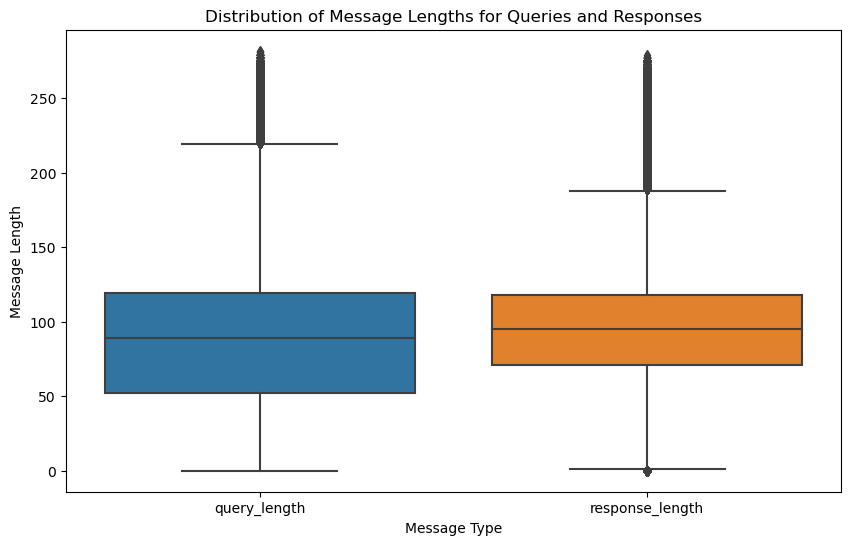

In [14]:
# function to display distribution of texts length
def plot_message_length_descriptions(df, query_column, response_column):
    """
    Plot the descriptive statistics of message lengths for queries and responses.
    Args:
    df (pd.DataFrame): DataFrame containing the data.
    query_column (str): Column name for query texts.
    response_column (str): Column name for response texts.
    """
    try:
        # Calculate message lengths
        df['query_length'] = df[query_column].str.len()
        df['response_length'] = df[response_column].str.len()

        # Prepare DataFrame for plotting
        length_df = df[['query_length', 'response_length']].melt(var_name='Type', value_name='Length')

        # Plotting
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Type', y='Length', data=length_df)
        plt.title('Distribution of Message Lengths for Queries and Responses')
        plt.ylabel('Message Length')
        plt.xlabel('Message Type')
        plt.show()
    
    except Exception as e:
        print(f"Error in plotting message length descriptions: {e}")

# Applying the function
plot_message_length_descriptions(df, 'query_text', 'response_text')

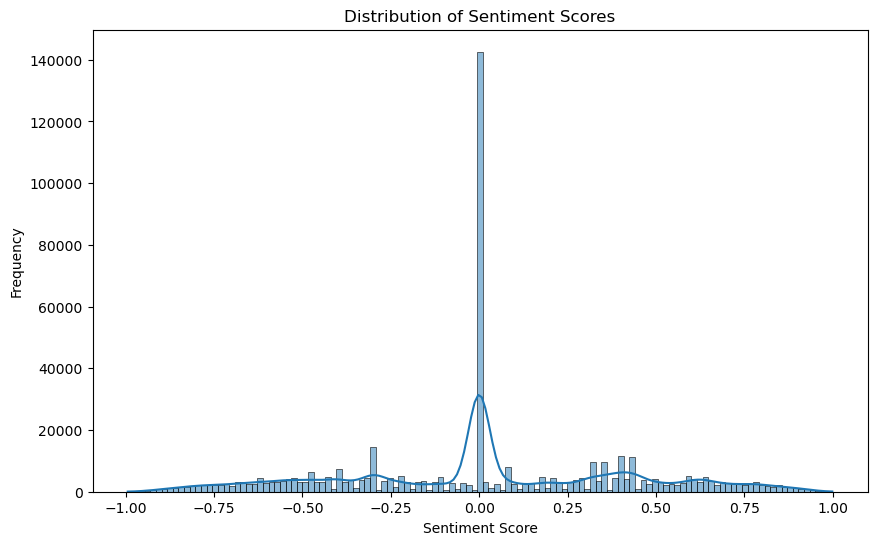

In [16]:
# plotting distribution of sentiment scores
try:
    plt.figure(figsize=(10, 6))
    sns.histplot(df['sentiment'], kde=True)
    plt.title('Distribution of Sentiment Scores')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Frequency')
    plt.show()
except Exception as e: 
    raise

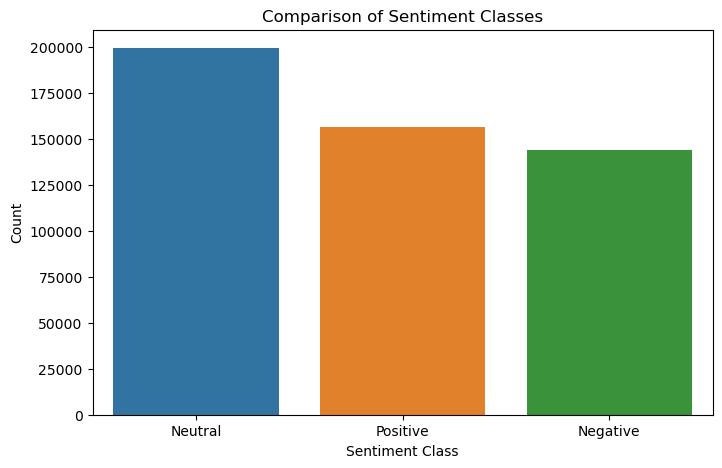

In [17]:
# comparing sentiment class accross df:
sentiment_counts = df['sentiment_class'].value_counts()

try:
    plt.figure(figsize=(8, 5))
    sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
    plt.title('Comparison of Sentiment Classes')
    plt.xlabel('Sentiment Class')
    plt.ylabel('Count')
    plt.show()
except Exception as e: 
    raise

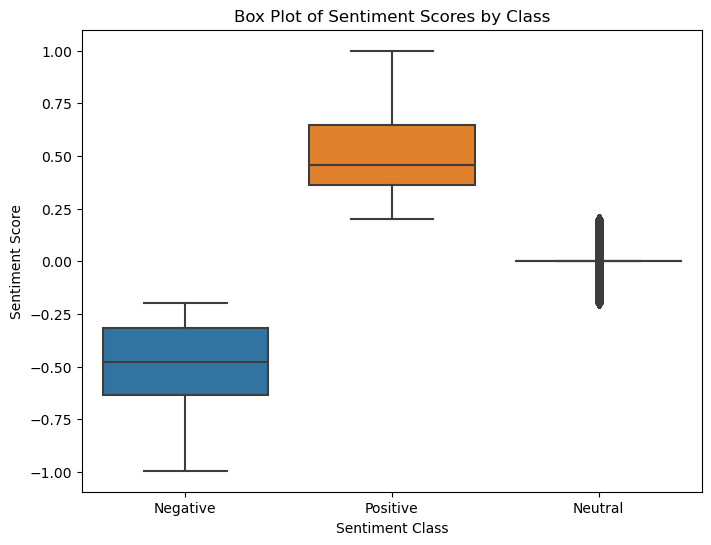

In [18]:
# Box Plot of Sentiment Scores
try:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='sentiment_class', y='sentiment', data=df)
    plt.title('Box Plot of Sentiment Scores by Class')
    plt.xlabel('Sentiment Class')
    plt.ylabel('Sentiment Score')
    plt.show()
except Exception as e: 
    raise

#### Saving Cleaned Dataset:

The data is now cleaned and modeled to be in ideal form for the preprocessing and modeling stages which will come in the next notebook. Below we defined a function to save the data and add it to the utils py script. 

In [19]:
# function to save data
def save_data(df, folder_path, file_name):
    """
    Saves the given DataFrame to a CSV file within the specified folder.
    df (pd.DataFrame): The DataFrame to be saved.
    folder_path (str): The path to the folder where the CSV file will be saved.
    file_name (str): The name of the CSV file.
    Returns:
    str: The full path to the saved CSV file, or None if an error occurred.
    """
    try:
        # Ensure the directory exists
        os.makedirs(folder_path, exist_ok=True)

        # Full path for the CSV file
        full_path = os.path.join(folder_path, file_name)

        # Save the DataFrame to CSV
        df.to_csv(full_path, index=False)
        
        logging.info(f"DataFrame saved successfully to {full_path}")
        return full_path
    except Exception as e:
        logging.error(f"Error saving the DataFrame to CSV: {e}")
        return None
# saving data
folder_path = '../data/'  # Adjust the path as needed
file_name = 'interim/cleaned_data.csv'
full_path = save_data(df, folder_path, file_name)

if full_path:
    print(f"DataFrame saved at: {full_path}")
else:
    print("Failed to save the DataFrame.")

2023-12-04 19:37:10,810 - INFO - DataFrame saved successfully to ../data/interim/cleaned_data.csv


DataFrame saved at: ../data/interim/cleaned_data.csv
